In [14]:
pip install bertopic

In [15]:
pip install faiss-cpu

In [27]:
import pandas as pd
import numpy as np
from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import PCA
from umap import UMAP
from sentence_transformers import SentenceTransformer
import nltk
from nltk.corpus import stopwords
import faiss
import matplotlib.pyplot as plt
from sentence_transformers import CrossEncoder
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [17]:
# Load cases
df = pd.read_csv("/content/cases.csv")
df["text"] = df["description"].fillna("") + " " + df["body"].fillna("") + " " + df["title"].fillna("")

In [18]:
# Initialize a sentence transformer model for embeddings
embedding_model = SentenceTransformer("all-mpnet-base-v2")

In [19]:
# Convert text to embeddings
embeddings = embedding_model.encode(df["text"].tolist(), show_progress_bar=True)

Batches:   0%|          | 0/71 [00:00<?, ?it/s]

In [20]:
# Initialize UMAP for dimensionality reduction
umap_model = UMAP(n_neighbors=15, n_components=3, min_dist=0.1, metric='cosine')

In [21]:
# Initialize vectorizer with stop words
vectorizer_model = CountVectorizer(stop_words=stopwords.words("english"))

In [22]:
# Create BERTopic model
topic_model = BERTopic(embedding_model=embedding_model, umap_model=umap_model, vectorizer_model=vectorizer_model)

In [23]:
# Fit model to text data
topics, probs = topic_model.fit_transform(df["text"].tolist(), embeddings)

In [24]:
# Add extracted topic info to the dataframe
df["topic"] = topics
df["topic_name"] = df["topic"].apply(lambda x: topic_model.get_topic(x) if x != -1 else "No Topic")

In [25]:
# Extract keywords for each topic
topic_keywords = topic_model.get_topics()

In [28]:
# Convert embeddings to NumPy array
embedding_array = np.array(embeddings).astype("float32")

# Normalize embeddings before adding to FAISS (for cosine similarity)
faiss.normalize_L2(embedding_array)

# Initialize FAISS index
index = faiss.IndexFlatIP(embedding_array.shape[1])
index.add(embedding_array)

# Save FAISS index for later use
faiss.write_index(index, "faiss_index.bin")

In [29]:
# Encode User Queries & Retrieve Similar Documents
def search_faiss(query, top_k=10):
    # Convert query to embedding
    query_embedding = embedding_model.encode([query]).astype("float32")

    # Search FAISS index
    distances, indices = index.search(query_embedding, top_k)

    # Retrieve matching documents
    results = df.iloc[indices[0]]  # Get rows from original dataframe
    return results

In [30]:
# Use a valid cross-encoder model
reranker = CrossEncoder("cross-encoder/ms-marco-MiniLM-L-12-v2")

def rerank_results(query, results):
    query_list = [query] * len(results)
    text_list = results["text"].tolist()

    # Get relevance scores from cross-encoder
    scores = reranker.predict(list(zip(query_list, text_list)))
    results["score"] = scores  # Add scores to dataframe

    # Normalize scores (optional, for better readability)
    results["normalized_score"] = (results["score"] - results["score"].min()) / (results["score"].max() - results["score"].min())

    return results.sort_values("score", ascending=False)

config.json:   0%|          | 0.00/791 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/133M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [31]:
# Update search function
def search_knn(query, top_k=10):
    """Retrieve top K nearest neighbors and rerank them."""
    # Convert query to embedding
    query_embedding = embedding_model.encode([query]).astype("float32")

    # Search FAISS index for top_k closest documents
    distances, indices = index.search(query_embedding, top_k)

    # Retrieve matching documents from original dataframe
    results = df.iloc[indices[0]]

    # Re-rank retrieved results
    reranked_results = rerank_results(query, results)

    return reranked_results, distances

Results:                                                    text  topic  \
1951  The Conference on the Future of Europe (May 9,...     15   
1379  On May 17, 2019, 120 European citizens from Fr...     15   
242   \nThe European Citizens’ Consultations brought...     15   
1693  The European Citizens’ Consultations brought t...     15   
1994  The European Union (EU)  organized this Confer...     15   

                                                  title  
1951                 Conference on the Future of Europe  
1379                 EU Citizens' Dialogue in The Hague  
242   The European Citizens' Consultation (2006 Agen...  
1693  The European Citizens' Consultation (2007 Events)  
1994                 Conference on the Future of Europe  
Distances: [[0.45209146 0.44640115 0.43764156 0.42814356 0.42756665]]


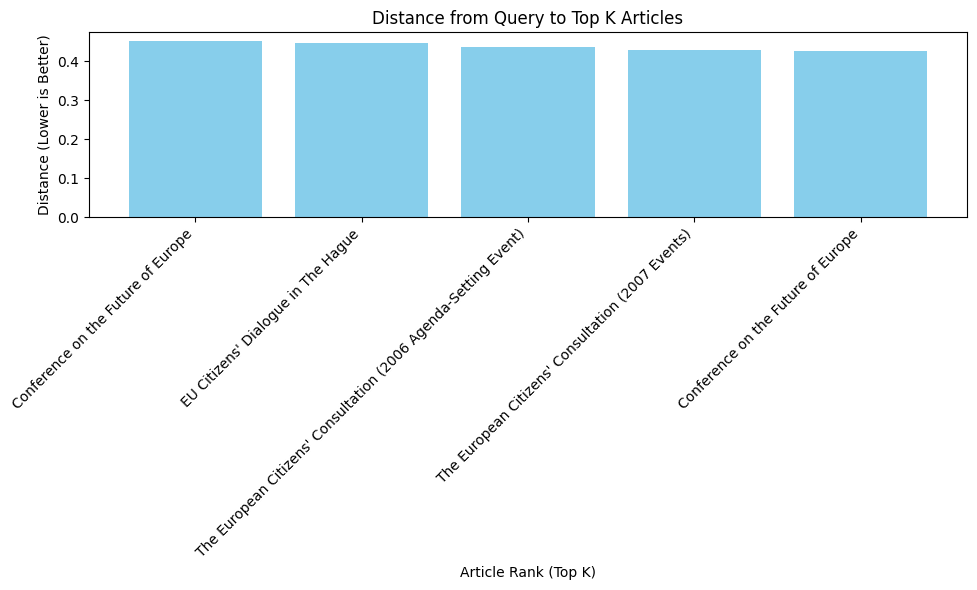

In [32]:
# Sample query
query = "I am looking for articles about human rights in europe"

# Retrieve top K closest articles to the query
results, distances = search_knn(query, top_k=5)

# Print results before filtering to check initial retrieval
print("Results:", results[["text", "topic", "title"]])

# Print distances (optional, to assess the closeness of matches)
print("Distances:", distances)

# Visualize the distances in a bar chart
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(distances[0]) + 1), distances[0], color='skyblue')
plt.xlabel('Article Rank (Top K)')
plt.ylabel('Distance (Lower is Better)')
plt.title('Distance from Query to Top K Articles')
plt.xticks(range(1, len(distances[0]) + 1), results['title'], rotation=45, ha='right')
plt.tight_layout()

# Show the plot
plt.show()